## Optimización de parametros con XGBoost

In [1]:
import pandas as pd

dataset_work_3 = pd.read_csv('D:\DataSet\dataset_work_transformed.csv')
x = dataset_work_3.iloc[:,:-1]
y = dataset_work_3.iloc[:,-1].values
dataset_work_3.shape

(6435823, 16)

In [2]:
import numpy as np
import time
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier

# Registro del tiempo de inicio
start_time = time.time()

# Separar las características (X) y la variable objetivo (y)
X = dataset_work_3.drop(columns=["MOROSIDAD"])
y = dataset_work_3["MOROSIDAD"]

# Escalado de características
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# División del conjunto de datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

# Espacio de búsqueda de hiperparámetros para XGBoost
param_dist = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'min_child_weight': [1, 5, 10],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 0.1, 0.2]
}

# Inicializar el clasificador y RandomizedSearchCV
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
random_search = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_dist,
    n_iter=10,  # Reducir o aumentar según el tiempo disponible
    cv=3,  # Validación cruzada con 3 folds
    n_jobs=-1,  # Usar todos los núcleos disponibles
    verbose=2,
    random_state=42,
    scoring='roc_auc'
)

# Ajustar el modelo con el conjunto de entrenamiento
random_search.fit(X_train, y_train)

# Obtener los mejores parámetros
print("Mejores parámetros encontrados:")
print(random_search.best_params_)

# Entrenar el modelo final con los mejores parámetros
best_params = random_search.best_params_
best_model = XGBClassifier(**best_params, use_label_encoder=False, eval_metric='logloss', random_state=42)

# Ajustar el modelo con el conjunto completo
best_model.fit(X_train, y_train)

# Hacer predicciones y evaluar el modelo
y_pred = best_model.predict(X_test)
y_pred_proba = best_model.predict_proba(X_test)[:, 1]

print("\nMatriz de Confusión:")
print(confusion_matrix(y_test, y_pred))

print("\nReporte de Clasificación:")
print(classification_report(y_test, y_pred))

roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f"ROC AUC: {roc_auc:.4f}")

# Medir el tiempo de finalización y calcular el tiempo transcurrido
end_time = time.time()
elapsed_time = end_time - start_time

# Convertir a minutos y segundos
minutes = elapsed_time // 60
seconds = elapsed_time % 60

print(f"El tiempo total de ejecución fue de {int(minutes)} minutos y {seconds:.2f} segundos.")


Fitting 3 folds for each of 10 candidates, totalling 30 fits


C:\Users\hrqui\AppData\Roaming\Python\Python310\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
3 fits failed out of a total of 30.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\hrqui\AppData\Roaming\Python\Python310\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\hrqui\AppData\Roaming\Python\Python310\site-packages\xgboost\core.py", line 726, in inner_f
    return func(**kwargs)
  File "C:\Users\hrqui\AppData\Roaming\Python\Python310\site-packages\xgboost\sklearn.py", line 1512, in fit
    train_dmatrix, evals = _wr

Mejores parámetros encontrados:
{'subsample': 0.8, 'n_estimators': 300, 'min_child_weight': 1, 'max_depth': 7, 'learning_rate': 0.2, 'gamma': 0.1, 'colsample_bytree': 0.6}


C:\Users\hrqui\AppData\Roaming\Python\Python310\site-packages\xgboost\core.py:158: UserWarning: [19:48:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Matriz de Confusión:
[[911324 209515]
 [136596 673312]]

Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.87      0.81      0.84   1120839
           1       0.76      0.83      0.80    809908

    accuracy                           0.82   1930747
   macro avg       0.82      0.82      0.82   1930747
weighted avg       0.82      0.82      0.82   1930747

ROC AUC: 0.9200
El tiempo total de ejecución fue de 17 minutos y 14.95 segundos.


## **Matriz de Confusión con Mapa de Calor**

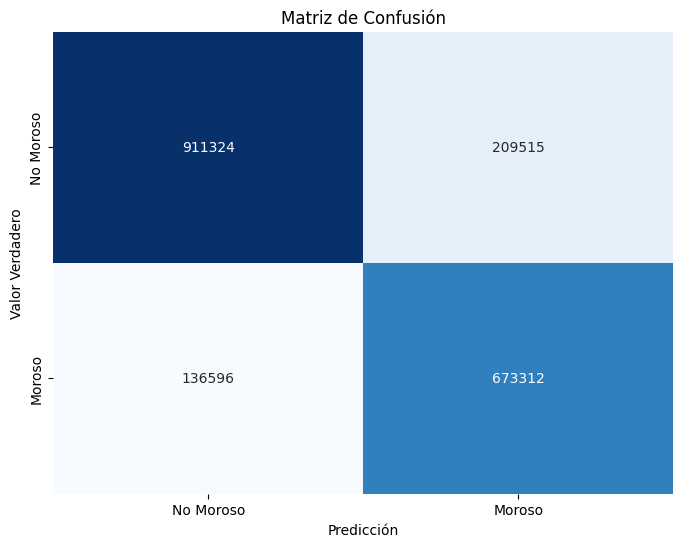

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt

conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['No Moroso', 'Moroso'], yticklabels=['No Moroso', 'Moroso'])
plt.title("Matriz de Confusión")
plt.xlabel("Predicción")
plt.ylabel("Valor Verdadero")
plt.show()